### Binary Classification Model for Kaggle Tabular Playground Series Mar 2021 Using Python and Scikit-Learn
### David Lowe
### June 2, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Mar 2021 dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The average performance of the machine learning algorithms achieved a ROC benchmark of 0.8430 using the training dataset. We selected Logistic Regression and Random Forest to perform the tuning exercises. After a series of tuning trials, the refined Random Forest model processed the training dataset with a final ROC score of 0.8901. When we processed Kaggle's test dataset with the final model, the model achieved a ROC score of 0.8902.

CONCLUSION: In this iteration, the Random Forest model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 Mar Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-mar-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-mar-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'roc_auc'

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont2     cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0   0    A    I    A    B    B   BI    A    S    Q  ...  0.759439  0.795549  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006   
1   1    A    I    A    A    E   BI    K    W   AD  ...  0.386385  0.541366  0.388982  0.357778  0.600044  0.408701  0.399353  0.927406   
2   2    A    K    A    A    E   BI    A    E   BM  ...  0.343255  0.616352  0.793687  0.552877  0.352113  0.388835  0.412303  0.292696   
3   3    A    K    A    C    E   BI    A    Y   AD  ...  0.831147  0.807807  0.800032  0.619147  0.221789  0.897617  0.633669  0.760318   
4   4    A    I    G    B    E   BI    C    G    Q  ...  0.338818  0.277308  0.610578  0.128291  0.578764  0.279167  0.351103  0.357084   

     cont10 target  
0  0.665915      0  
1  0.493729      0  
2  0.549452      0  
3  0.934242      0  
4  0.328960      1  

[5 rows x 32 columns]


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [12]:
print(df_dataset_import.describe())

                  id          cont0          cont1          cont2          cont3          cont4          cont5          cont6  \
count  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000   
mean   250183.425697       0.504749       0.494073       0.516632       0.474235       0.504848       0.502257       0.488229   
std    144320.334812       0.206788       0.213037       0.214851       0.216636       0.227474       0.241243       0.211335   
min         0.000000      -0.049562       0.084480       0.094493      -0.045316       0.168071      -0.036379       0.005199   
25%    125399.750000       0.344985       0.317363       0.326047       0.292249       0.279303       0.276442       0.323914   
50%    250192.500000       0.479650       0.463170       0.471247       0.387564       0.479858       0.554768       0.518089   
75%    375246.250000       0.637657       0.693992       0.704625       0.644950       0.725779  

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont2     cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0    A    I    A    B    B   BI    A    S    Q    A  ...  0.759439  0.795549  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006   
1    A    I    A    A    E   BI    K    W   AD    F  ...  0.386385  0.541366  0.388982  0.357778  0.600044  0.408701  0.399353  0.927406   
2    A    K    A    A    E   BI    A    E   BM    L  ...  0.343255  0.616352  0.793687  0.552877  0.352113  0.388835  0.412303  0.292696   
3    A    K    A    C    E   BI    A    Y   AD    F  ...  0.831147  0.807807  0.800032  0.619147  0.221789  0.897617  0.633669  0.760318   
4    A    I    G    B    E   BI    C    G    Q    A  ...  0.338818  0.277308  0.610578  0.128291  0.578764  0.279167  0.351103  0.357084   

     cont10  target  
0  0.665915       0  
1  0.493729       0  
2  0.549452       0  
3  0.934242       0  
4  0.328960       1  

[5 rows x 31 columns]


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [16]:
print(df_dataset_import.describe())

               cont0          cont1          cont2          cont3          cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504749       0.494073       0.516632       0.474235       0.504848       0.502257       0.488229       0.501739   
std         0.206788       0.213037       0.214851       0.216636       0.227474       0.241243       0.211335       0.203496   
min        -0.049562       0.084480       0.094493      -0.045316       0.168071      -0.036379       0.005199       0.090901   
25%         0.344985       0.317363       0.326047       0.292249       0.279303       0.276442       0.323914       0.353054   
50%         0.479650       0.463170       0.471247       0.387564       0.479858       0.554768       0.518089       0.435404   
75%         0.637657       0.693992       0.704625       0.644950       0.725779       0.735225  

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 31) df_features_train.shape: (300000, 30) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

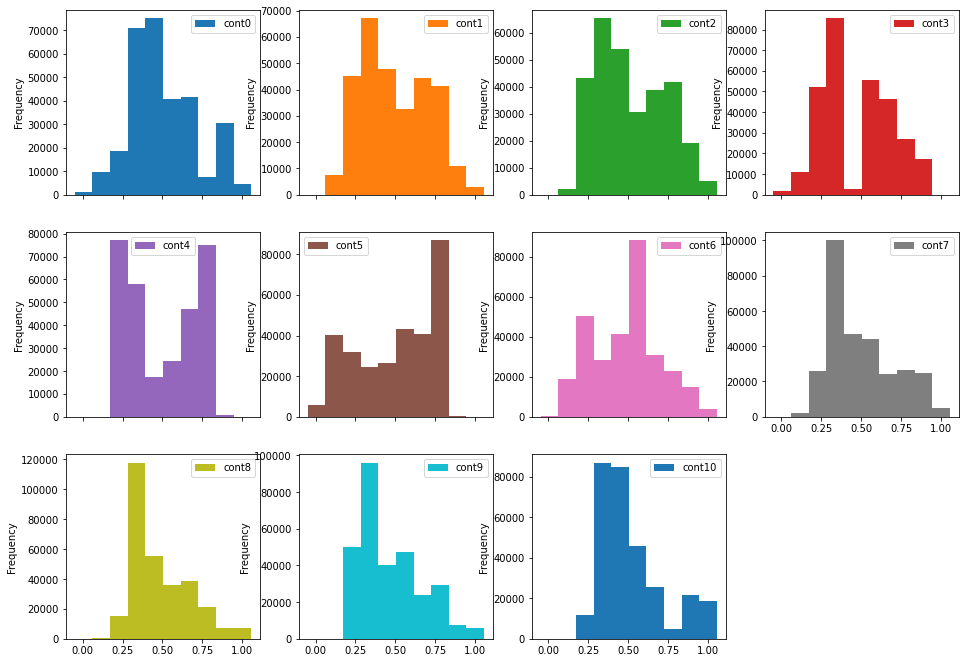

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

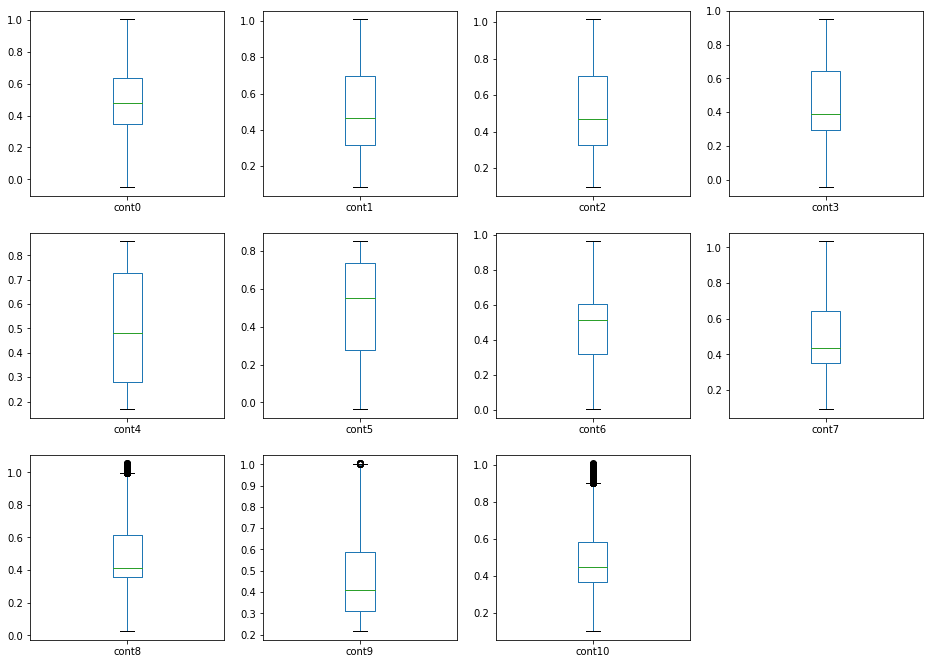

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

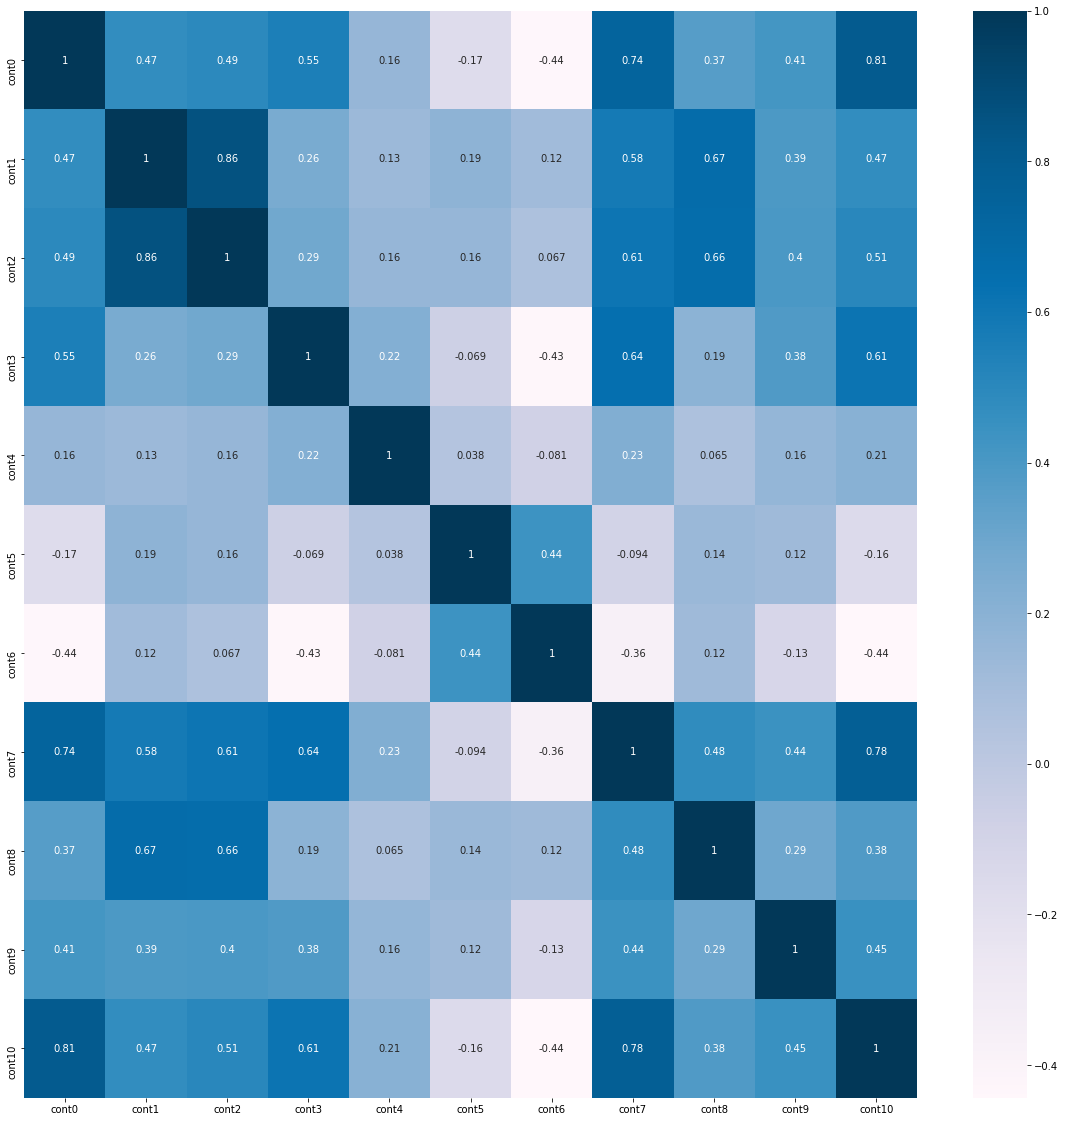

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0))
#     ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 11
Number of categorical columns: 19
Total number of columns in the feature dataframe: 30


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (300000, 30) to array_features_train.shape: (300000, 634)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 634) array_target_train.shape: (300000,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('CART', DecisionTreeClassifier(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=N_JOBS)))
train_models.append(('BGT', BaggingClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)))

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+SCORING_METRIC+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LGR: 0.882844 (0.001201)
LogisticRegression(n_jobs=2, random_state=888)
Model training time: 0:01:16.836866 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.714992 (0.001201)
DecisionTreeClassifier(random_state=888)
Model training time: 0:04:57.128620 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 61.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: 0.836491 (0.001425)
KNeighborsClassifier(n_jobs=2)
Model training time: 1:00:59.155826 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 15.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.854120 (0.001307)
BaggingClassifier(n_jobs=2, random_state=888)
Model training time: 0:15:14.575447 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  9.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.887084 (0.001236)
RandomForestClassifier(n_jobs=2, random_state=888)
Model training time: 0:09:13.999700 

EXT: 0.882665 (0.001086)
ExtraTreesClassifier(n_jobs=2, random_state=888)
Model training time: 0:11:30.653553 

Average metrics (roc_auc) from all models: 0.8430326710183921
Total training time for all models: 1:43:12.375567


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 11.5min finished


### 4.b) Spot-checking baseline algorithms

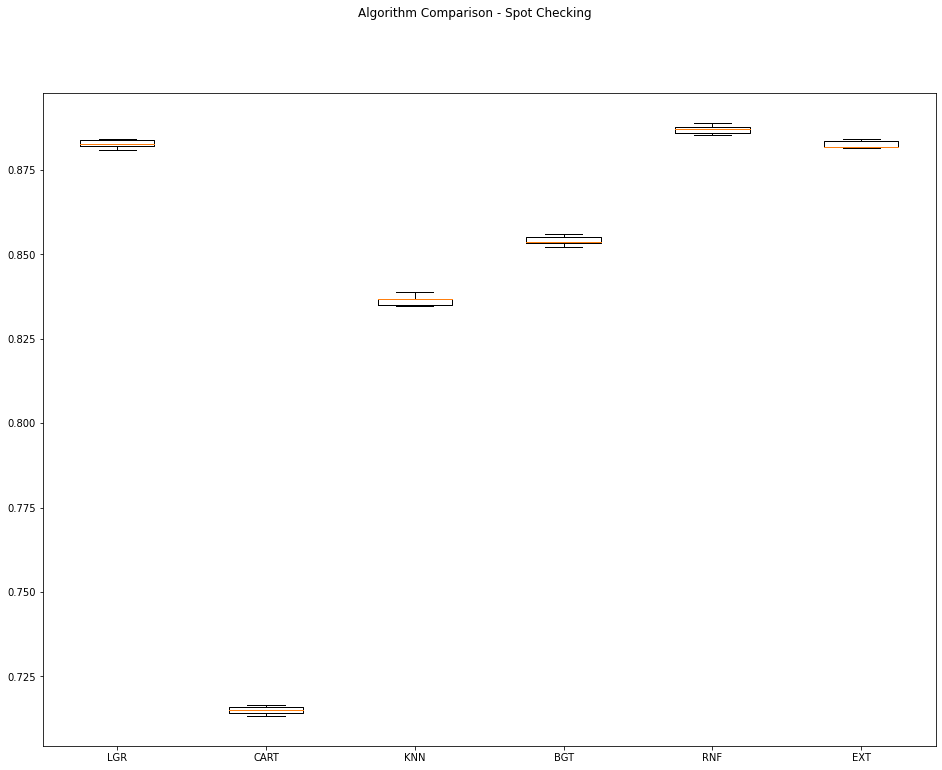

In [38]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = LogisticRegression(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('LGR')
paramGrid1 = dict(C=np.array([0.01, 0.1, 1, 10]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.882955 using {'C': 0.1}
0.882426 (0.001251) with: {'C': 0.01}
0.882955 (0.001220) with: {'C': 0.1}
0.882844 (0.001201) with: {'C': 1.0}
0.882763 (0.001224) with: {'C': 10.0}
Model training time: 0:14:08.131094


In [43]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: C = 0.1


In [44]:
# Tuning algorithm #2 - Random Forest
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=RNG_SEED, n_jobs=N_JOBS)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 250, 500, 750]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.890178 using {'n_estimators': 750}
0.887084 (0.001236) with: {'n_estimators': 100}
0.889287 (0.001130) with: {'n_estimators': 250}
0.889944 (0.001152) with: {'n_estimators': 500}
0.890178 (0.001076) with: {'n_estimators': 750}
Model training time: 2:55:11.940474


In [45]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 750


### 5.b) Compare Algorithms After Tuning

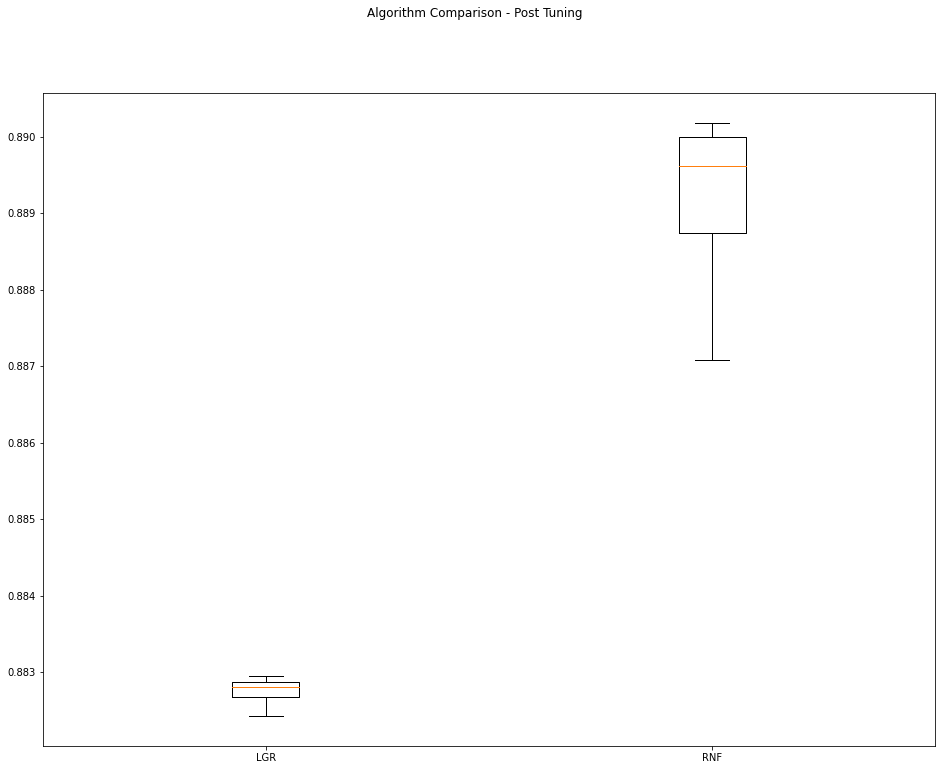

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [48]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [49]:
final_model = RandomForestClassifier(n_estimators=best_paramValue2, random_state=RNG_SEED, n_jobs=N_JOBS)
final_model.fit(array_features_train, array_target_train)
print(final_model)

RandomForestClassifier(n_estimators=750, n_jobs=2, random_state=888)


### 6.b) Load Test Dataset and Prepare the Submission File

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8  \
0   5    A    F    A    A    F   BI    A   AH   AX  ...  0.735690  0.578366  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331   
1   6    A    H    C    A    E   AB    I    F    N  ...  0.313703  0.928885  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944   
2   8    A    N    C    A    F   AB    A   AH   BC  ...  0.448201  0.424876  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238   
3   9    B    L    C    A    F   BI    A    E   AX  ...  0.666092  0.598943  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660   
4  11    A    F    A    B    F   BI    A   AH    I  ...  0.772229  0.479572  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491   

      cont9    cont10  
0  0.359987  0.947489  
1  0.565520  0.388580  
2  0.252289  0.411592  
3  0.348514  0.325723  
4  0.466261  0.585781  

[5 rows x 31 columns

In [51]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   5
1   6
2   8
3   9
4  11


In [52]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont1     cont2     cont3     cont4     cont5     cont6     cont7     cont8  \
0    A    F    A    A    F   BI    A   AH   AX    A  ...  0.735690  0.578366  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331   
1    A    H    C    A    E   AB    I    F    N    A  ...  0.313703  0.928885  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944   
2    A    N    C    A    F   AB    A   AH   BC    A  ...  0.448201  0.424876  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238   
3    B    L    C    A    F   BI    A    E   AX    A  ...  0.666092  0.598943  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660   
4    A    F    A    B    F   BI    A   AH    I    A  ...  0.772229  0.479572  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491   

      cont9    cont10  
0  0.359987  0.947489  
1  0.565520  0.388580  
2  0.252289  0.411592  
3  0.348514  0.325723  
4  0.466261  0.585781  

[5 rows x 30 c

In [53]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (200000, 30) to array_features_test.shape: (200000, 634)


In [54]:
# Make batched predictions
test_predictions = final_model.predict_proba(array_features_test)[:,1]
print(test_predictions)

[0.14933333 0.51333333 0.004      ... 0.664      0.18266667 0.36533333]


In [55]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   5  0.149333
1   6  0.513333
2   8  0.004000
3   9  0.128000
4  11  0.113333


In [56]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210602-2131.csv


In [57]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 5:24:13.928865
